In [1]:
from matplotlib import pyplot as plt
import cv2
from IPython.display import Video # To display the video in the notebook
import numpy as np

In [2]:
def get_video_frames(path, no_frames = 1000):
    """
    Gets a path to the video to be read
    Args:
        path: string to the path of the video
        no_frames: int, specifies the number of frames to be read from the video
    Returns:
        a list of complete frames. Each complete frame is a list containing the Y,Cb,Cr components of each frame
    """
    vid = cv2.VideoCapture(path)
    # Initialize a np array to hold all frames.
    vid_frame = []
    # Read until video is completed
    for i in range(no_frames):
            if vid.isOpened() == 0:
                print("couldn't open video")
            # Capture frame-by-frame
            ret, frameRGB = vid.read()
            if ret == True:
                # Convert frame to YUV with 4:2:0 sampling
                frameYUV = cv2.cvtColor(frameRGB, cv2.COLOR_RGB2YUV_I420)

                # Get frame components
                rows, cols = frameYUV.shape 
                Y_row = np.int(rows - rows*1/3)
                frame_Y = frameYUV[0:Y_row, :]

                frame_Cb1 = frameYUV[Y_row:np.int(Y_row*1.25),0: np.int(cols/2)]
                frame_Cr1 = frameYUV[np.int(Y_row*1.25):np.int(Y_row*1.5), 0: np.int(cols/2)]

                frame_Cb2 = frameYUV[Y_row:np.int(Y_row*1.25), np.int(cols/2):]
                frame_Cr2 = frameYUV[np.int(Y_row*1.25):np.int(Y_row*1.5), np.int(cols/2):]

                complete_frame = np.array([frame_Y,frame_Cb1,frame_Cr1,frame_Cb2,frame_Cr2])

                # Add frame to list of frames
                vid_frame.append(complete_frame)
            # Break the loop
            else: 
                break
    return vid_frame

In [3]:
def conv_decom_YUV2RGB(complete_frame):
    """
    Gets a list containing all the components of a YUV in this order [Y, Cb1, Cr1, Cb2, Cr2], then combine them all together
    and convert them to their RGB equivilant
    Args:
        complete_frame: a list of the 5 YUV components
    Returns:
        an RGB OpenCV frame (3d numpy array) that is ready to be shown with cv2.imshow()
    """
    rows, cols = complete_frame[0].shape[0]+complete_frame[1].shape[0]*2, complete_frame[0].shape[1]
    Y_row = np.int(rows - rows*1/3)
    
    frame1 = np.zeros((rows,cols), dtype= np.uint8)
    frame1[0:Y_row, : ] = complete_frame[0]
    frame1[Y_row:np.int(Y_row*1.25),0: np.int(cols/2)] = complete_frame[1]
    frame1[np.int(Y_row*1.25):np.int(Y_row*1.5), 0: np.int(cols/2)] = complete_frame[2]
    frame1[Y_row:np.int(Y_row*1.25), np.int(cols/2):]  = complete_frame[3]
    frame1[np.int(Y_row*1.25):np.int(Y_row*1.5), np.int(cols/2):] = complete_frame[4]
    
    return cv2.cvtColor(frame1, cv2.COLOR_YUV2RGB_I420)

In [4]:
frames = get_video_frames('mountain.mp4')

In [5]:
cv2.imshow('image',conv_decom_YUV2RGB(frames[1]))
cv2.waitKey(0)
cv2.destroyAllWindows()

In [6]:
def reshape_image(image, box_size = 16):

    n_rows = np.int(np.floor(image.shape[0]/box_size))
    n_cols = np.int(np.floor(image.shape[1]/box_size))

    image_array = cv2.resize(image, dsize=(n_cols*box_size, n_rows*box_size))
    return image_array

def get_sub_images(image_array, box_size=16):
    """
    Gets a grayscale image and returns an array of (box_size, box_size) elements
    Args:
        image_array (numpy ndarray): Image input we want to divide to box
                                     sub_images.
         Should have shape (length, width, n_channels) where length = width
          e. g. n_channels = 3 for RGB
         box_size (int): Size of the box sub images
    Returns:
        divided_image (numpy ndarray, dtype = "uint8"): array of divided images
         - should have a shape of (X, box_size, box_size, n_channels).
        n_rows: number of rows or blocks
        n_cols: number of columns in image
          the number of blocks is n_rows*n_cols
    """
    n_rows = np.int(image_array.shape[0]/box_size)
    n_cols = np.int(image_array.shape[1]/box_size)

    # make the image into a square to simplify operations based
    #  on the smaller dimension
    # d = min(n_cols, n_rows)

    # Note: images are converted to uint8 datatypes since they range between
    #  0-255. different datatypes might misbehave (based on my trials)
    image_blocks = np.asarray([np.zeros((box_size, box_size), dtype='uint8')
                               for i in range(n_rows*n_cols)], dtype='uint8')

    # break down the image into blocks
    c = 0
    for i in range(n_rows):
        for j in range(n_cols):
            image_blocks[c] = image_array[i*box_size: i*box_size+box_size,
                                          j*box_size:j*box_size+box_size]
            c += 1

    # If you want to reconvert the output of this function into images,
    #  use the following line:
    # block_image = Image.fromarray(output[idx])

    return image_blocks, n_rows, n_cols


def get_reconstructed_image(divided_image, n_rows, n_cols, box_size=8):
    """
    Gets an array of (box_size,box_size) pixels
    and returns the reconstructed image
    Args:
        divided_image (numpy ndarray, dtype = "uint8"): array of divided images
        n_rows: number of rows or blocks
        n_cols: number of columns in image
            the number of blocks is n_rows*n_cols
        box_size (int): Size of the box sub images
    Returns:
        reconstructed_image (numpy ndarray): Image reconstructed from the array
        of divided images.

    """
    image_reconstructed = np.zeros((n_rows*box_size, n_cols*box_size), dtype=np.uint8)
    c = 0
    # break down the image into blocks
    for i in range(n_rows):
        for j in range(n_cols):
            image_reconstructed[i*box_size: i*box_size+box_size, 
                                j*box_size:j*box_size+box_size] = divided_image[c]
            c += 1
            
    # If you want to reconvert the output of this function into images,
    #  use the following line:
    # block_image = Image.fromarray(output[idx])

    return image_reconstructed


Dimensions of the ref image is  (720, 960)
Dimensions of the ref divided is (2700, 16, 16)


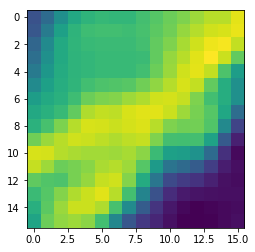

In [7]:
vid_frame = frames
frame_rows, frame_cols = frames[0][0].shape
im_blocks_ref, n_rows, n_cols = get_sub_images(reshape_image(vid_frame[100][0]))
#im_blocks_p, __, __ = get_sub_images(reshape_image(vid_frame[300][0]))
print('Dimensions of the ref image is ', vid_frame[0][0].shape)
print('Dimensions of the ref divided is', im_blocks_ref.shape)

plt.imshow(im_blocks_ref[1000])

In [291]:
motion_vecs = np.zeros((2,2700), dtype= np.int).reshape(np.int(frame_rows/16),np.int(frame_cols/16),2)
motion_vecs[30:35, 20:23] = [13,-5]
im_rec = get_reconstructed_image(im_blocks_ref, n_rows, n_cols, box_size=16)
print(n_rows, n_cols)

45 60


In [292]:
def predict(image_blocks, motion_vecs, p_rows, p_cols):
    """
    Gets: An array of serial image blocks with each block of size 16, 16 and constructs an image of each block moved by
    a corresponding motion vector.
    Args: 
        image_blocks: 1D array of image 16x16 blocks 
        motion_vecs: motion vectors corresponding to the blocks in image_blocks.
        p_rows: rows of predicted frame (constant for all frames)
        p_cols: columns of predicted frame (constant for all frames)
    Returns: 
        predicted_image: an image where each block has been moved to its predicted place according to its motion vector
    """
    predicted_image = get_reconstructed_image(image_blocks, np.int(p_rows/16), np.int(p_cols/16), box_size=16)
    image_blocks = image_blocks.reshape(np.int(p_rows/16),np.int(p_cols/16),16,16)   #contruct the image first with no movements
    
    for i in range(np.int(p_rows/16)):
        for j in range(np.int(p_cols/16)):
            vector = motion_vecs[i,j]
            # checking for image boundaries to avoid any out of bound indecies 
            if i*16 + vector[1] + 16 <= p_rows and i*16 + vector[1] >=0 and j*16 + vector[0] + 16 <= p_cols and j*16 + vector[0] >= 0:
                # move only the blocks where motion vector is not 0 
                if vector[0] != 0 or vector[1] != 0:
                    predicted_image[i*16 + vector[1] : i*16 + vector[1] + 16, j*16 + vector[0] : j*16 + vector[0] + 16] = image_blocks[i,j]
                    
    return predicted_image

In [293]:
p_image = predict(im_blocks_ref, motion_vecs, frame_rows, frame_cols)

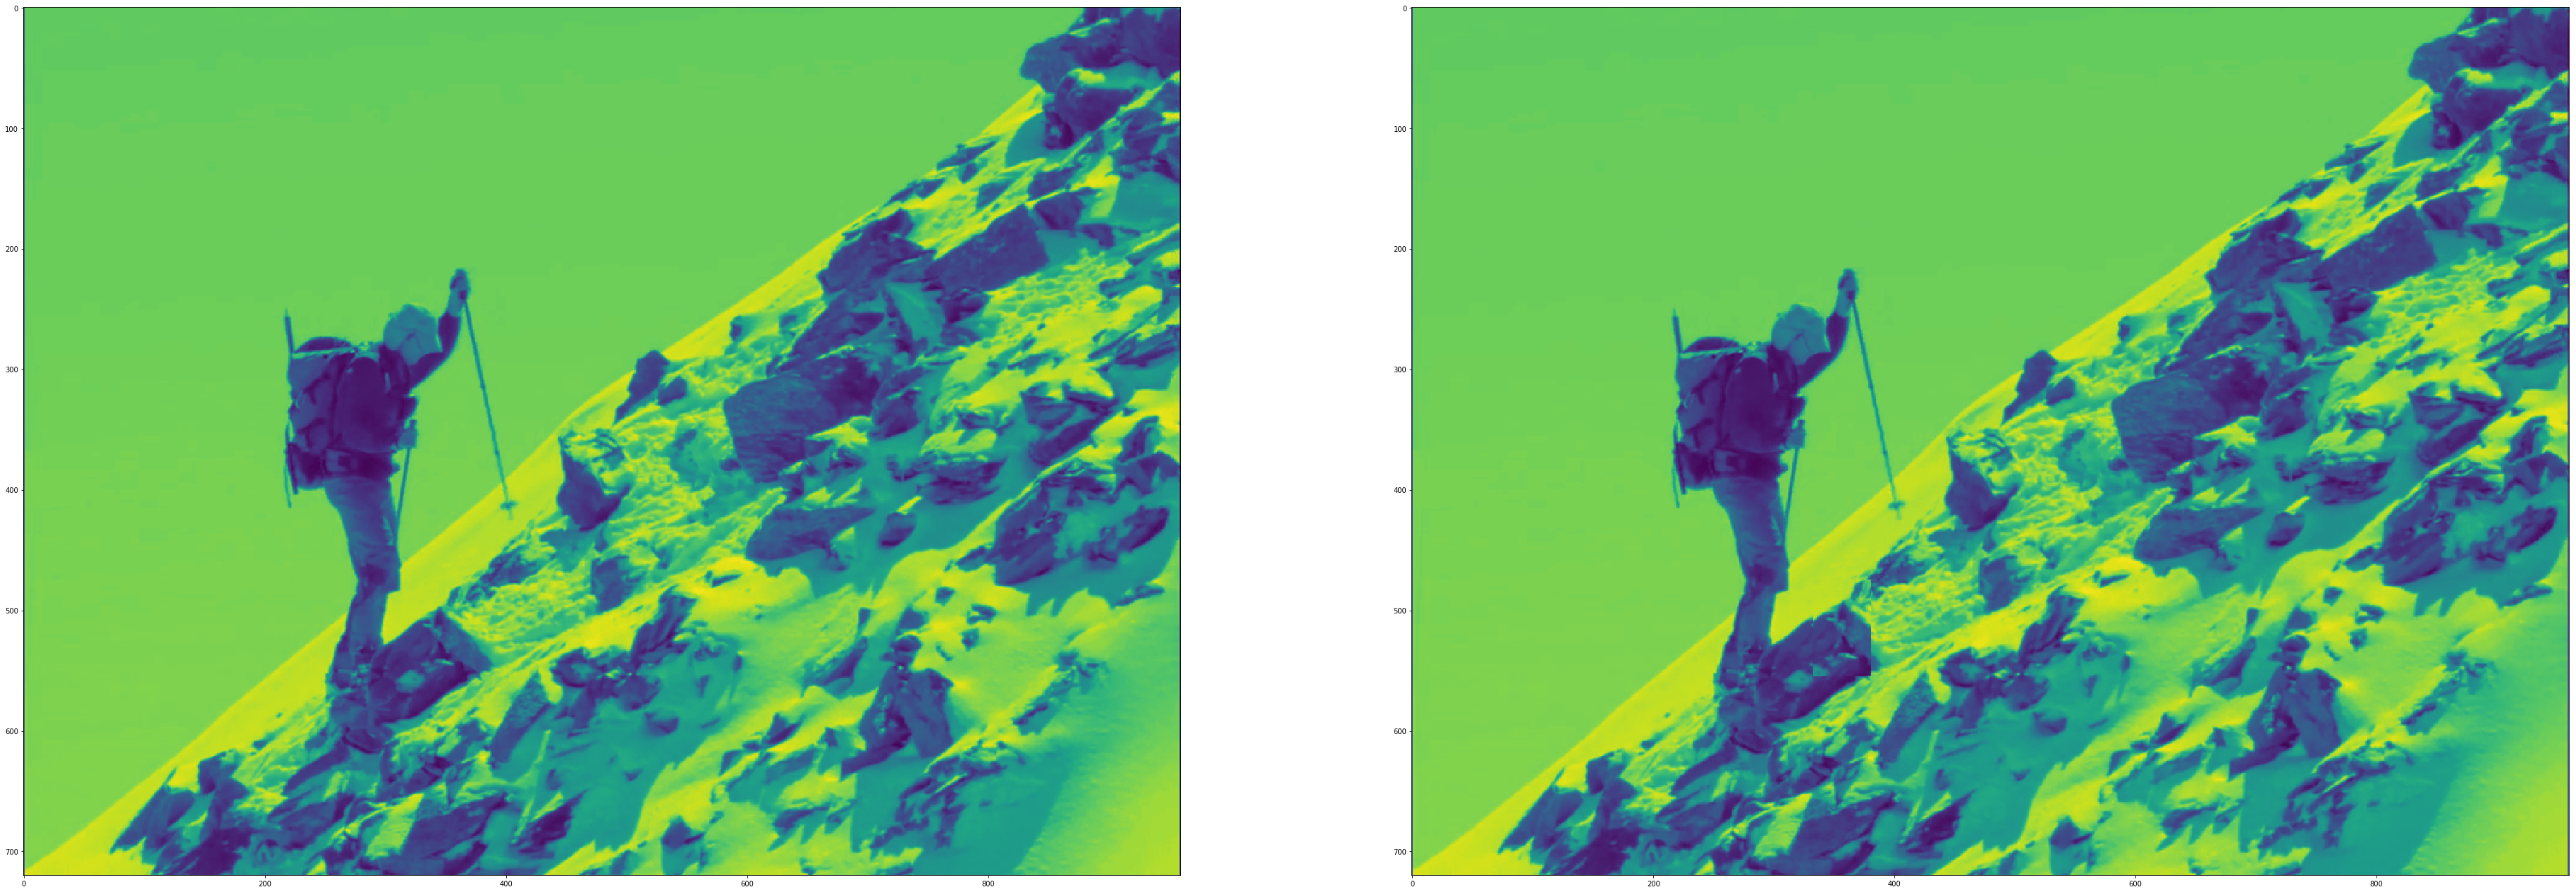

In [294]:
plt.figure(figsize=(100,100))
plt.subplot(131)
plt.imshow(im_rec)
plt.subplot(132)
plt.imshow(p_image)

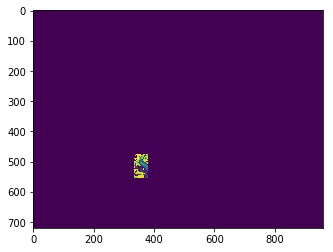

In [295]:
plt.imshow(im_rec - p_image)
